<a href="https://colab.research.google.com/github/BrianaNzivu/AWSLambda-Practice/blob/main/Scancer_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

import cv2
from matplotlib.image import imread

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

import glob
import PIL
import random
import zipfile
from google.colab import drive

# For consistent results
random.seed(100)

In [4]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Change directory to my dataset location
os.chdir('/content/drive/MyDrive/Dataset_BUSI_with_GT')

print(os.listdir())

['normal', 'malignant', 'benign']


Number of images in benign: 891
Number of images in malignant: 878
Number of images in normal: 878


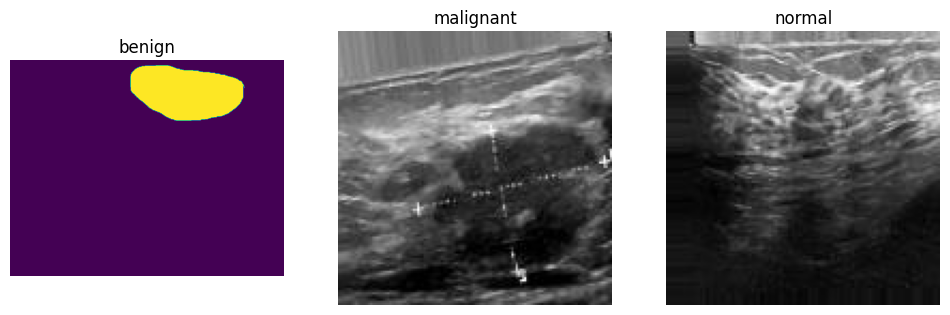

In [19]:
# Count images in each class
for class_name in ['benign', 'malignant', 'normal']:
    class_path = os.path.join('/content/drive/MyDrive/Dataset_BUSI_with_GT', class_name)
    num_images = len(os.listdir(class_path))
    print(f"Number of images in {class_name}: {num_images}")

# Visualize random images
plt.figure(figsize=(12, 6))
for i, class_name in enumerate(['benign', 'malignant', 'normal']):
    class_path = os.path.join('/content/drive/MyDrive/Dataset_BUSI_with_GT', class_name)
    random_image_path = os.path.join(class_path, random.choice(os.listdir(class_path)))
    img = imread(random_image_path)
    plt.subplot(1, 3, i+1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')
plt.show()

In [18]:
# Data Augmetation to make sure for Malignant and Normal t have same no. as Benign
image_size = 128

# Data augmentation setup
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Count images in 'benign' class to determine target number
benign_path = os.path.join('/content/drive/MyDrive/Dataset_BUSI_with_GT', 'benign')
target_images = len(os.listdir(benign_path))

# Augment 'malignant' and 'normal' classes
for class_name in ['malignant', 'normal']:
    class_path = os.path.join('/content/drive/MyDrive/Dataset_BUSI_with_GT', class_name)
    num_augmentations = 0
    augmentations_needed = max(0, target_images - len(os.listdir(class_path)))

    for image_name in os.listdir(class_path):
        if num_augmentations >= augmentations_needed:
            break  # Stop augmenting if target reached

        image_path = os.path.join(class_path, image_name)
        img = cv2.imread(image_path)
        img = cv2.resize(img, (image_size, image_size))
        img = img.reshape((1,) + img.shape)

        i = 0
        for batch in datagen.flow(img, batch_size=1, save_to_dir=class_path, save_prefix='augmented_', save_format='jpeg'):
            i += 1
            num_augmentations += 1
            if i > 5 or num_augmentations >= augmentations_needed:
                break

In [27]:
#Preprocessing and Feature Extraction
images = []
labels = []

# Load and preprocess all images
for class_name in ['benign', 'malignant', 'normal']:
    class_path = os.path.join('/content/drive/MyDrive/Dataset_BUSI_with_GT', class_name)
    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)
        img = cv2.imread(image_path)
        img = cv2.resize(img, (image_size, image_size))

        # Contrast Enhancement (using CLAHE)
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        gray_img = clahe.apply(gray_img) # Apply CLAHE to grayscale image

        # Noise Reduction (using Gaussian Blur)
        gray_img = cv2.GaussianBlur(gray_img, (5, 5), 0)

        # Edge Detection (using Canny)
        gray_img = cv2.Canny(gray_img, 100, 200)

        # Normalize pixel values
        img = img / 255.0
        images.append(img)
        labels.append(class_name)

# Convert labels to numerical values
label_mapping = {'benign': 0, 'malignant': 1, 'normal': 2}
labels = [label_mapping[label] for label in labels]

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

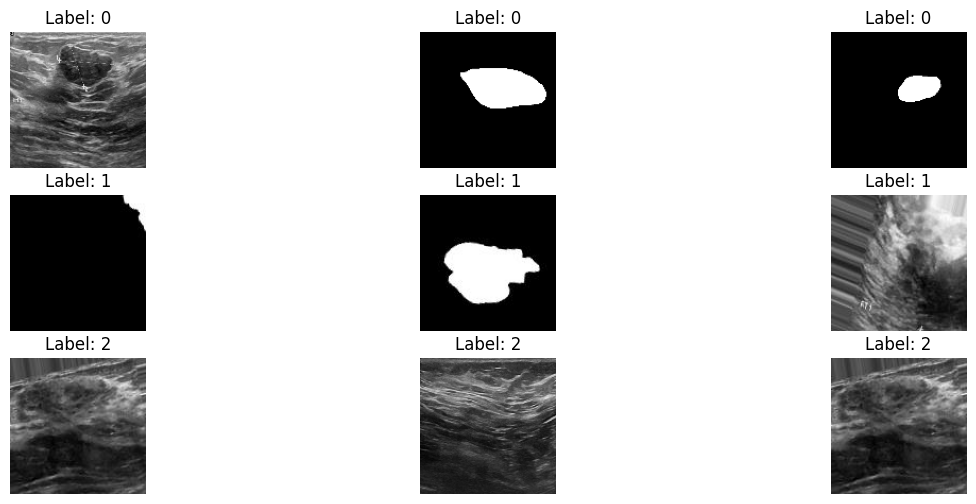

In [29]:
# Display a few preprocessed sample images
label_0_indices = np.where(labels == 0)[0]
label_1_indices = np.where(labels == 1)[0]
label_2_indices = np.where(labels == 2)[0]

# Display a few sample images from each label
plt.figure(figsize=(15, 6))
for i, label_indices in enumerate([label_0_indices, label_1_indices, label_2_indices]):
    for j in range(3):
        random_index = np.random.choice(label_indices)
        plt.subplot(3, 3, i * 3 + j + 1)
        plt.imshow(images[random_index], cmap='gray')
        plt.title(f"Label: {labels[random_index]}")
        plt.axis('off')
plt.show()